### Imports

In [29]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_validate
from sklearn import svm
from scipy.spatial import distance

### Helper functions

In [22]:
def plot_1(x, y, xlabel, ylabel, title, x_lim, y_lim, line=False):
    plt.figure()
    plt.plot(x, y, color='magenta', lw=2)
    if line:
        plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.xlim(x_lim);
    plt.ylim(y_lim);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);
    plt.show();

In [23]:
def plot_2(x1, y1, x2, y2, xlabel, ylabel, title, legend_labels):
    plt.figure()
    plt.plot(x1, y1, color='magenta', lw=2)
    plt.plot(x2, y2, color='darkorange', lw=2, linestyle='--')
    plt.legend(legend_labels)
    plt.xlim([800,8000]);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);
    plt.show();

In [24]:
def perform_cross_validation(clf, data, labels, folds, metrics):    
    cv = cross_validate(clf, data, labels, scoring=metrics, cv=folds, return_train_score=True)    
    return cv

### Questions

In [25]:
# Q1
def classify(train_file, test_file):
    
    #creating dataframes for train and test sets
    X_train = pd.read_csv(train_file)
    X_test = pd.read_csv(test_file)

    # using f1_macro as scoring parameter for grid serach
    metric = 'f1_macro'

    # developing pipeline of features and classifier
    clf = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    # dictionary of hyperparameters to be tuned
    params = {        
        'tfidf__min_df':[1,2,3],
        'tfidf__stop_words':[None,'english'],
        'clf__alpha':[0.5,1,2]
    }

    # developing gridsearch model
    gs_clf = GridSearchCV(clf, param_grid=params, scoring=metric, cv=5)

    # fitting model on train set for hyperparameter tuning
    gs_clf_fitted = gs_clf.fit(X_train['text'], X_train['label'])

    # printing best params 
    for param in gs_clf_fitted.best_params_:
        print(param, ":", gs_clf_fitted.best_params_[param])

    print("Best f1_macro: ", gs_clf_fitted.best_score_ )

    # probabilities on test dataset
    pred_prob = gs_clf_fitted.predict_proba(X_test['text'])

    predictions = gs_clf_fitted.predict(X_test['text'])

    # reporting metrics
    print(classification_report(X_test['label'], predictions, target_names=None))   

    # required plots
    precision, recall, thresholds = precision_recall_curve(X_test['label'], pred_prob[:,1], pos_label=2)

    fpr, tpr, thresholds = roc_curve(X_test['label'], pred_prob[:,1], pos_label=2)

    # precision-recall curve
    plot_1(recall, precision, "Recall", 'Precision', "Precision vs Recall curve" , [0.0, 1.0], [0.0, 1.1])

    # Roc-curve
    plot_1(fpr, tpr, "False positive rate", 'True positive rate', "Roc Curve" , [0.0, 1.0], [0.0, 1.1], True)

    # calculate auc
    print('AUC Score: ',auc(fpr, tpr))

In [26]:
# Q2
def impact_of_sample_size(train_file):    

    df = pd.read_csv(train_file)

    # list of metrics
    f1_macro_mnb = []
    f1_macro_svm = []
    roc_auc_mnb = []
    roc_auc_svm = []

    for i in range(800, 8400, 400):

        X_train = df.loc[:i-1]  

        metrics = ['f1_macro', 'roc_auc']
        
        # number of folds for cross-validation
        folds = 5

        # step1: tfidfvectorizer
        dtm = TfidfVectorizer(stop_words='english').fit_transform(X_train['text'])

        #step2: MultinomialNB
        clf1 = MultinomialNB()
        cv_mnb = perform_cross_validation(clf1, dtm, X_train['label'], folds, metrics)    

        #step3: Linear SVM
        clf2 = svm.LinearSVC()
        cv_svm = perform_cross_validation(clf2, dtm, X_train['label'], folds, metrics)

        #ste4: collect metrics
        f1_macro_mnb.append(np.mean(cv_mnb['test_f1_macro']))
        roc_auc_mnb.append(np.mean(cv_mnb['test_roc_auc']))
        f1_macro_svm.append(np.mean(cv_svm['test_f1_macro']))
        roc_auc_svm.append(np.mean(cv_svm['test_roc_auc']))
    
    # required plots
    plot_2(range(800, 8400, 400), f1_macro_svm, range(800, 8400, 400),f1_macro_mnb, 
           "size", '', "" , ['f1_svm', 'f1_nb'])

    plot_2(range(800, 8400, 400), roc_auc_svm, range(800, 8400, 400),  roc_auc_mnb, 
           "size", '', "" , ['auc_svm', 'auc_nb'])

In [31]:
#Q3
def classify_duplicate(filename):
    
    auc = None    
    
    ##### Feature Engineering #####
    
    df = pd.read_csv(filename)
    y = df['is_duplicate']
    
    # tf-idf matrix
    tfidf_ = TfidfVectorizer(ngram_range=(1, 8), analyzer='char_wb', strip_accents='ascii',sublinear_tf=True)\
                            .fit_transform((df['q1'].append(df['q2']))).toarray()
    
    # combining tf-idf of question-pair into single matrix
    tfidf_sum = tfidf_[500:, :] + tfidf_[:500,:]
    
    ## cosine similarity ##
    
    # we will get 1000x1000 similarity matrix with q1 and q2 list concated. 
    # hence, slicing from 500 to get pairwise similarity for each q1 and q2                                      
    pairwise_matrix = 1-distance.squareform(distance.pdist(tfidf_, 'cosine'))[:500,500:]
    sim = [pairwise_matrix[i][i] for i in range(500)]
    
    # adding question cosine similarities as feature in combined tf-idf matrix
    data_ = np.hstack((tfidf_sum, np.array(sim).reshape(500,1))) 
    
    ##### Training model #####
    
    # Using SVM with radial basis function kernel for classification
    clf = svm.SVC(kernel='rbf', gamma='auto') 
    cv_svm = perform_cross_validation(clf, data_, y, 5, ['roc_auc'])
    
    ##### Report scores #####
    
    # auc scores on test set using 5-fold cross validation
    test_auc = cv_svm['test_roc_auc']

    # average AUC
    auc = np.mean(test_auc)
    
    return auc

### Test module

Q1: ####################
clf__alpha : 2
tfidf__min_df : 1
tfidf__stop_words : None
Best f1_macro:  0.7134380001639543
              precision    recall  f1-score   support

           1       0.74      0.76      0.75        99
           2       0.76      0.74      0.75       102

   micro avg       0.75      0.75      0.75       201
   macro avg       0.75      0.75      0.75       201
weighted avg       0.75      0.75      0.75       201



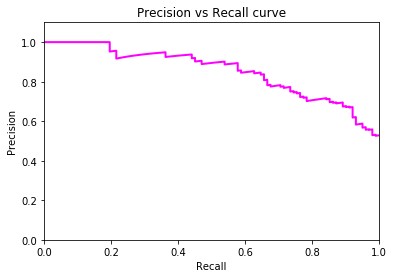

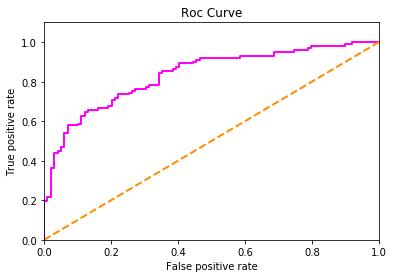

AUC Score:  0.835016835016835

Q2: ####################


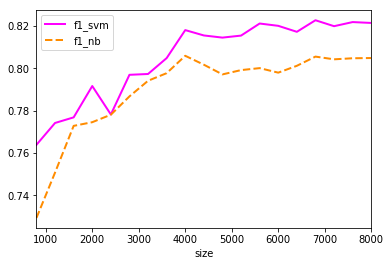

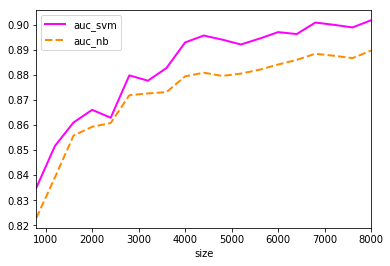


Q3: ####################
0.7693565589398923


In [33]:
if __name__ == "__main__":
    
    # Test Q1
    print("Q1: ####################")
    classify("train.csv", "test.csv")
    print("")

    # Test Q2
    print("Q2: ####################")
    impact_of_sample_size("train_large.csv")
    print("")
    
    # Test Q3
    print("Q3: ####################")
    result = classify_duplicate("quora_duplicate_question_500.csv")
    print("Average AUC: ",result)